**Daehyun Cho Neuroimaging(BRI609) HW1**

*Note that numbered headers refer to the workflow of what I did, and alphabetic headers refer to the assignment*   
*Also note that some codes are commented due to too many outputs it spit out...*

# [0] Data Preparation

## 0.1 Import

In [1]:
import math, random
from itertools import product
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob

from IPython.display import clear_output

import nibabel as nib
from nibabel.brikhead import *

## 0.2 Load Data
For this stage, I aimed to make -
+ for each task(ad, lh, rh, vs)
+ for each subjects,
+ not all voxels, but their ROIs respectively **averaged**
 
which ends up with data shape of `(# subs, x, y, z, bold by time)` for each task respectively

### 0.2.1 Load ROI Mask

In [2]:
masks = { # {task: [(x, y, z) ...]}
    k: [(x, y, z) for x, y, z in zip(*np.where(nib.load(v).get_fdata() != 0)[:-1])]
    for k, v in zip(['ad', 'lh', 'rh', 'vs'], glob('./stats/ttest/*.gz'))
}

### 0.2.2 Load BOLD Signal

In [3]:
tasks = ['ad', 'lh', 'rh', 'vs']
sub_ids = range(2, 14)
get_img = lambda x: nib.load(x).get_fdata()

BOLD = {task: dict() for task in tasks}
BOLD_voxel = {task: dict() for task in tasks}
for sub_id in sub_ids:
    sub_id = f'{str(sub_id).zfill(2)}'
    dir_sub_id = glob(f'./data/s{sub_id}/ad_lh_rh_vs/s{sub_id}.results/*.brik')
    
    for i, task in enumerate(tasks):
        BOLD[task][sub_id] = get_img(dir_sub_id[i])
        
        BOLD_voxel[task][sub_id] = np.array([BOLD[task][sub_id][p] for p in masks[task]])
        BOLD[task][sub_id] = sum(BOLD[task][sub_id][p] for p in masks[task]) / len(masks[task])

Now each task dictionary contains for each subjects averaged BOLD signal of their ROIs. For example auditory task(`ad`), subject 02's bold signals are as followed

In [4]:
BOLD['ad']['02']

array([712.71224976, 711.59639486, 715.65416463, 714.17563883,
       712.99129028, 713.13711141, 713.43453979, 714.50793864,
       715.3414388 , 714.24032186, 714.13745728, 712.94888306,
       715.91298625, 720.51322835, 716.42850545, 712.49010213,
       711.36983846, 711.86590169, 712.38032633, 715.66875407,
       715.06452433, 714.90030721, 713.24330037, 714.30494181,
       714.73956502, 711.46162923, 710.234198  , 710.14152425,
       712.74313965, 712.50687866])

In [5]:
# BOLD_voxel['ad']['02']

### 0.a Each of the task was performed at 20s during 4s (i.e., 10, 11 TRs). Please use boxcar model for neural activity

So if 10, 11 TR was activated, we should make neuronal activity that looks like the one below

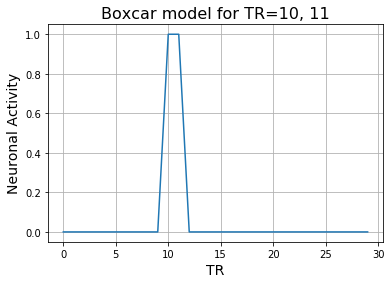

In [6]:
# BOXCAR
boxcar = np.array(
    [0] * 10 +
    [1] * 2  +
    [0] * 18
)

# PLOT
plt.plot(boxcar)
plt.title('Boxcar model for TR=10, 11', fontsize=16)
plt.xlabel('TR', fontsize=14)
plt.ylabel('Neuronal Activity', fontsize=14)
plt.grid()
plt.show()

### 0.b Consider the 0-20s, (i.e. 0 - 9 TRs) and 40-60s(i.e. 20 - 29 TRs) as baseline period.

Since baseilne period should be made by task and subject all respectively(making 11 * 4, which is too many), I'll make a function for this, so I can get the baseline whenever I want

In [7]:
baseline = lambda task, sub_id: (sum(BOLD[task][sub_id][0:10]) + sum(BOLD[task][sub_id][20:])) / 20

In [8]:
baseline_voxel = lambda task, sub_id: [(sum(voxel[0:10]) + sum(voxel[20:])) / 20 for voxel in BOLD_voxel[task][sub_id]]

For example, if I want to get the baseline of subject 02's auditory task baseline BOLD signal, just type - 

In [9]:
baseline('ad', '02')

713.3565548706055

In [10]:
# baseline_voxel('lh', '02')

### 0.c Calculate the percentage(%) BOLD (pBOLD) signal based on (b)

In [11]:
def pBOLD(task, sub_id):
    
    base = baseline(task, sub_id)
    return (BOLD[task][sub_id] - base) / base * 100

In [12]:
def pBOLD_voxel(task, sub_id):
    
    base = baseline_voxel(task, sub_id)
    return ((BOLD_voxel[task][sub_id].T - base) / base * 100).T

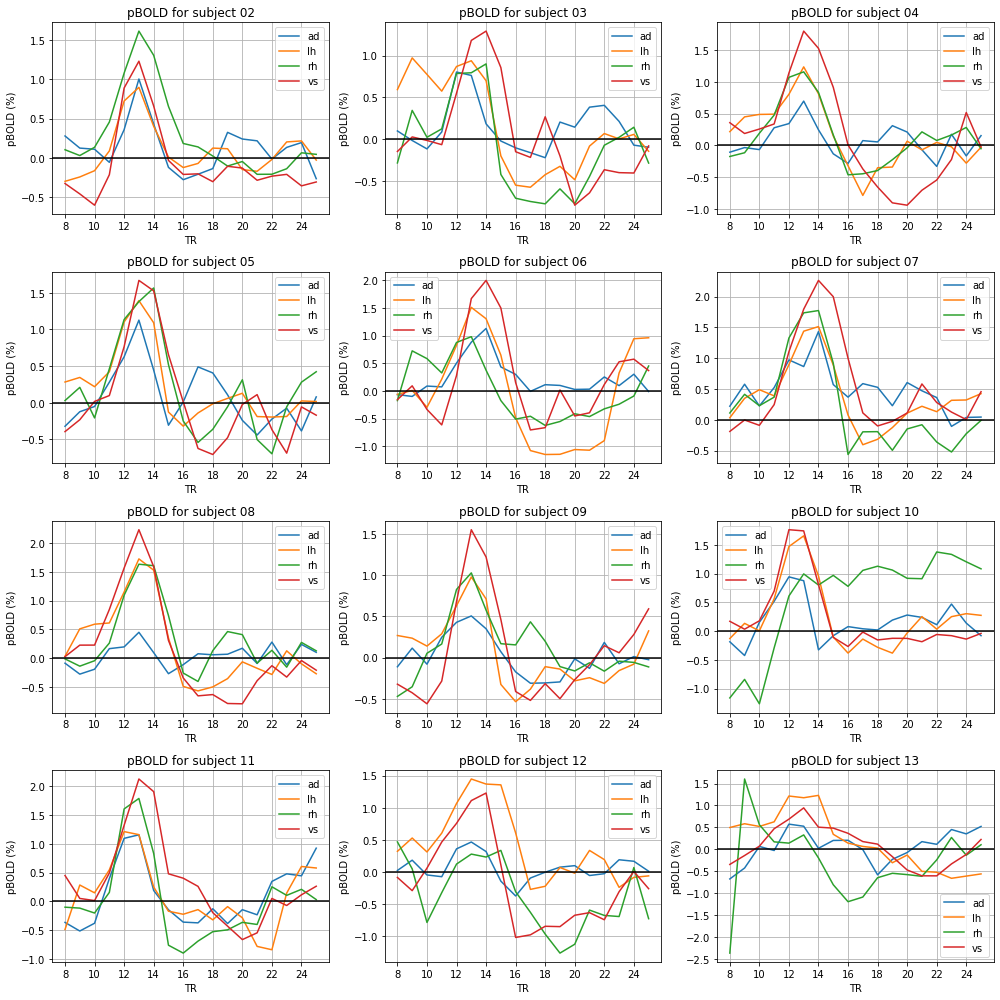

In [13]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(14, 14))
for sub_id in sub_ids:
    
    row, col = (sub_id - 2) // 3, (sub_id - 2) % 3
    sub_id = f'{str(sub_id).zfill(2)}'
    for task in tasks:
        axes[row, col].plot(pBOLD(task, sub_id)[8:26], label=task)
        
    axes[row, col].grid()
    axes[row, col].set_title(f'pBOLD for subject {sub_id}')
    axes[row, col].set_xlabel('TR')
    axes[row, col].set_xticks(np.arange(0, 18, step=2))
    axes[row, col].set_xticklabels([f'{i+8}' for i in range(0, 18) if not i % 2])
    axes[row, col].set_ylabel('pBOLD (%)')
    axes[row, col].axhline(0, color='black')
    axes[row, col].legend()
    
fig.tight_layout()

I drew an `y=0` in order to clearly see the baseline.

### 0.d Conduct the estimation of HRFs using the pBOLD signals calculated in (c) by applying each of the following methods [1] - [4]

Now we conduct the estimation.

# [1] Deconvolution Approach

### 1.a Set the reasonable number of Fast Fourier Transform (FFT) points

Use TR=8

### 1.b Perform the FFT and inverse FFT to estimate the HRF in the time domain for each of the voxels in the ROI

In [ ]:
def deconvolution(bold, boxcar=None):
    
    if boxcar is None:
        boxcar = np.array(
            [0] * 10 +
            [1] * 2  +
            [0] * 18
        )
        
    return np.fft.ifft(np.fft.fft(bold) / np.fft.fft(boxcar))

In [ ]:
neu1 = np.array([0] * 2 + [1] * 2 + [0] * 14)
neu2 = np.array([0] * 2 + [1] * 2 + [0] * 4)
neu3 = np.array([1] * 2 + [0] * 4)

In [ ]:
deconvolution(pBOLD['ad']['02'], neu1)

### 1.c Check the estimated HRFs across the voxels and average the estimated HRFs

### 1.d Evaluate your results by comparing the average estimated HRF and average pBOLD signal

# [2] Using a flexible mathematical model of HRF - One Gamma Function

### 2.a Set the reasonable range of values as a grid for each of the parameters (i.e. $T_0$, $n$, and $\lambda$)

I'll denote the variables as follows
+ $T_0$ as `T0`
+ $n$ as `n`
+ $\lambda$ as `l`

In [30]:
params_one = {
    'T0': [0],
    'n' : [i * .1 for i in range(30, 50)],
    'l' : [i * .1 for i in range(20, 70)]
}

### 2.b Calculate Pearsons's correlation coefficients(CC) between the pBOLD signal and estimated pBOLD from the modeled HRF across all combinatorial sets of model parameters for *each voxel*

Phew, there are much things to be done here.
1. Make `one_gamma` function - *remember to use TR=9~25 only*
2. Get combintaions of parameter grids
3. Calculate Pearson's Correlation

### 2.1 Make `one_gamma` function

In [15]:
fact = math.factorial
def one_gamma(params: list, t=None):
    
    t0, n, l = params
    if t is None: t = np.arange(0, 18)
    return (t - t0)**(n-1) / (l**n * math.gamma(n)) * np.exp(-t/l)

In [16]:
def two_gamma(params: list, t=None):

    t0, n1, l1, a, n2, l2 = params
    if t is None:
        t = np.arange(0, 18)
    
    term1 = (t - t0)**(n1-1) / (l1**n1 * math.gamma(n1)) * np.exp(-t/l1)
    term2 = (t - t0)**(n2-1) / (l2**n2 * math.gamma(n2)) * np.exp(-t/l2)
    return term1- a * term2

See if it looks fine

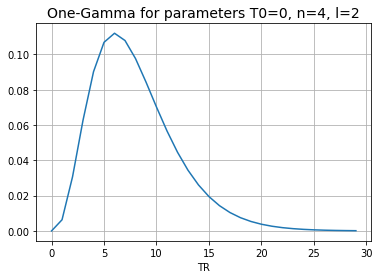

In [17]:
plt.plot(one_gamma([0, 4, 2], t=np.arange(0, 30)))
plt.title('One-Gamma for parameters T0=0, n=4, l=2', fontsize=14)
plt.xlabel('TR')
plt.grid()

Let's see how graphs change as we change the parameters.

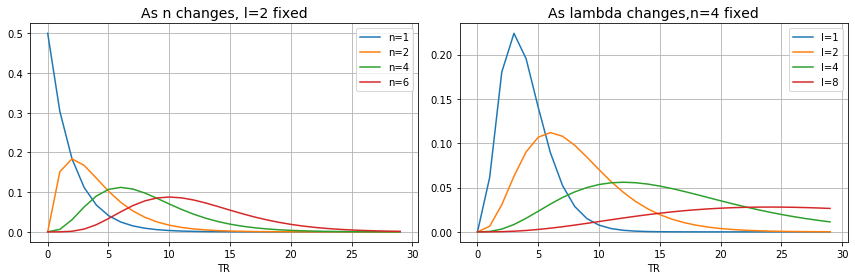

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

n = [1, 2, 4, 6]
l = [1, 2, 4, 8]

# As n changes
axes[0].set_title('As n changes, l=2 fixed', fontsize=14)
axes[0].plot(one_gamma([0, n[0], 2], t=np.arange(0, 30)), label=f'n={n[0]}')
axes[0].plot(one_gamma([0, n[1], 2], t=np.arange(0, 30)), label=f'n={n[1]}')
axes[0].plot(one_gamma([0, n[2], 2], t=np.arange(0, 30)), label=f'n={n[2]}')
axes[0].plot(one_gamma([0, n[3], 2], t=np.arange(0, 30)), label=f'n={n[3]}')
axes[0].set_xlabel('TR')
axes[0].legend()
axes[0].grid()

# As l changes
axes[1].set_title('As lambda changes,n=4 fixed', fontsize=14)
axes[1].plot(one_gamma([0, 4, l[0]], t=np.arange(0, 30)), label=f'l={l[0]}')
axes[1].plot(one_gamma([0, 4, l[1]], t=np.arange(0, 30)), label=f'l={l[1]}')
axes[1].plot(one_gamma([0, 4, l[2]], t=np.arange(0, 30)), label=f'l={l[2]}')
axes[1].plot(one_gamma([0, 4, l[3]], t=np.arange(0, 30)), label=f'l={l[3]}')
axes[1].set_xlabel('TR')
axes[1].legend()
axes[1].grid()

fig.tight_layout()

### 2.2 Get combinations of parameter grid

Since there are too many cases of parameters to consider, I can't iterate them all by myself. Make a function for this.

In [19]:
cases = lambda cases: list(product(*cases.values()))

So that it conatins all the set of parameters seen as below

In [20]:
cases(params_one)[:10]

[(0, 2.0, 1.0),
 (0, 2.0, 1.1),
 (0, 2.0, 1.2000000000000002),
 (0, 2.0, 1.3),
 (0, 2.0, 1.4000000000000001),
 (0, 2.0, 1.5),
 (0, 2.0, 1.6),
 (0, 2.0, 1.7000000000000002),
 (0, 2.0, 1.8),
 (0, 2.0, 1.9000000000000001)]

with each case, I can make HRF. Let's plot some sampling from cases.

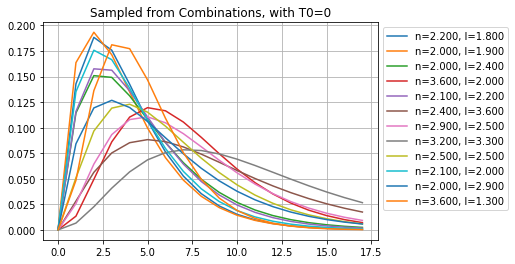

In [21]:
for i in range(12):
    
    sample = random.choice(cases(params_one))
    T0, n, l = sample
    plt.plot(one_gamma(sample), label=f'n={n:.3f}, l={l:.3f}')
    plt.legend(bbox_to_anchor=(1, 1))
    
plt.title('Sampled from Combinations, with T0=0')
plt.grid()

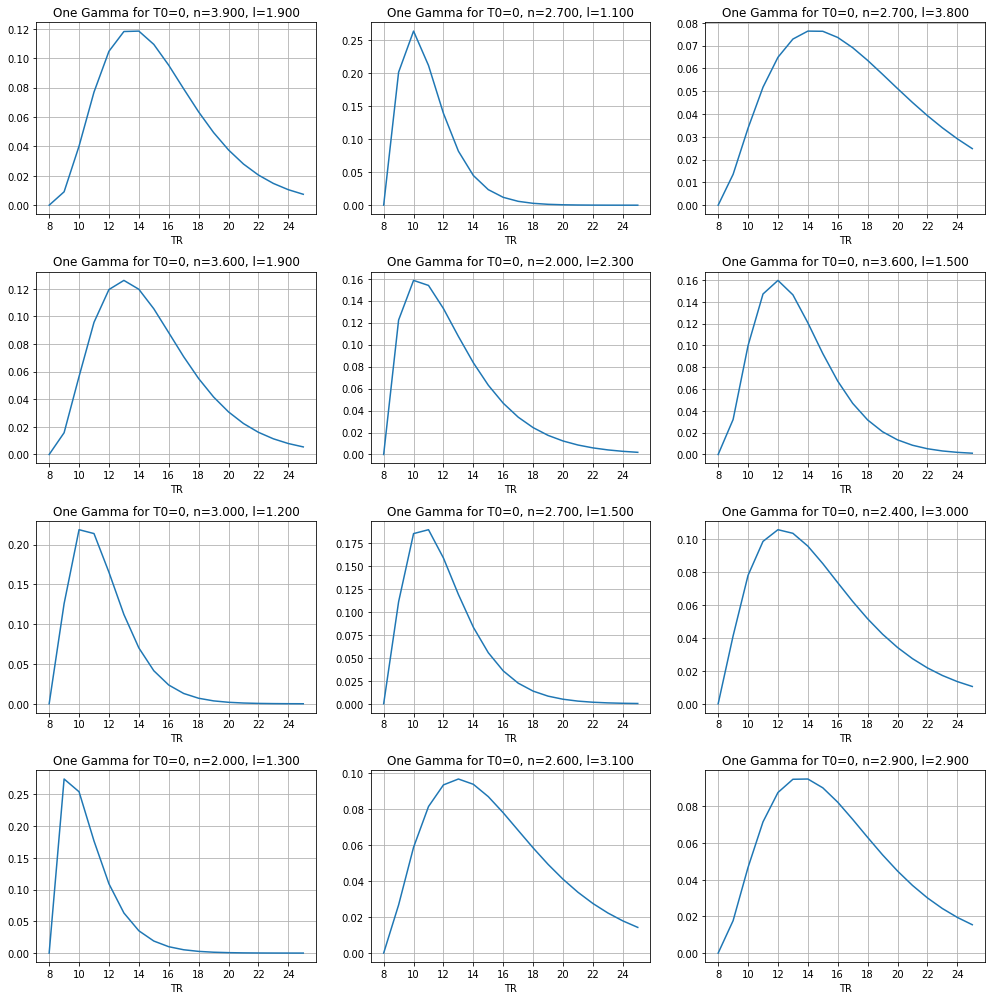

In [22]:
fig, axes = plt.subplots(4, 3, figsize=(14, 14))
for i in range(12):
    
    row, col = i // 3, i % 3
    sample = random.choice(cases(params_one))
    
    axes[row, col].plot(one_gamma(sample))
    T0, n, l = sample
    axes[row, col].set_title(f'One Gamma for T0={T0}, n={n:.3f}, l={l:.3f}')
    axes[row, col].set_xlabel('TR')
    axes[row, col].set_xticks(np.arange(0, 18, step=2))
    axes[row, col].set_xticklabels([f'{i+8}' for i in range(0, 18) if not i % 2])
    axes[row, col].grid()
    
fig.tight_layout()

### 2.3 Calculate Correlations

In [23]:
corr = lambda bold, hrf: np.corrcoef(bold[8:26], hrf)[0][1]

In [24]:
corr(pBOLD('ad', '02'), one_gamma(sample))

0.180059001383807

In [25]:
corr_voxel = lambda bold_voxel, hrf:[np.corrcoef(voxel[8:26], hrf)[0][1] for voxel in bold_voxel]

In [26]:
corr_voxel(pBOLD_voxel('ad', '02'), one_gamma(sample))

[0.27703637242000195,
 0.3352310784374744,
 0.26259369867732785,
 0.1981303709713015,
 0.23997750206981036,
 0.13756204782256576,
 0.1492879972377446,
 0.20141998826853702,
 0.3150754094107413,
 0.15628282878187227,
 0.011240778105257506,
 0.09488444017646709,
 -0.013722071367662698,
 0.14997700411762935,
 0.2533464550823617,
 0.0341811118250237,
 0.34521086616841,
 0.058203217983595325,
 0.015539969979706782,
 -0.13259313191742805,
 -0.014122836783461308,
 0.01146604454187871,
 0.03135702461720317,
 -0.011660107398363873,
 0.162620528680509,
 0.07505596377222008,
 0.10252461539928877,
 0.28669103419493497,
 0.07535031165056313,
 0.2032407128658281]

In [27]:
zfill = lambda x: str(x).zfill(2)
def get_corr_voxel(task, params):

    if len(params) == 3:
        hrf = one_gamma(params)
        
    elif len(params) ==  6:
        hrf = two_gamma(params)
        
    return pd.DataFrame({
            f'{zfill(sub_id)}': corr_voxel(pBOLD_voxel(task, f'{zfill(sub_id)}'), hrf)
            for sub_id in sub_ids
        })

Now I can draw a heatmap of correlations for each -
+ task
+ subject
+ voxels of interest   

For, example

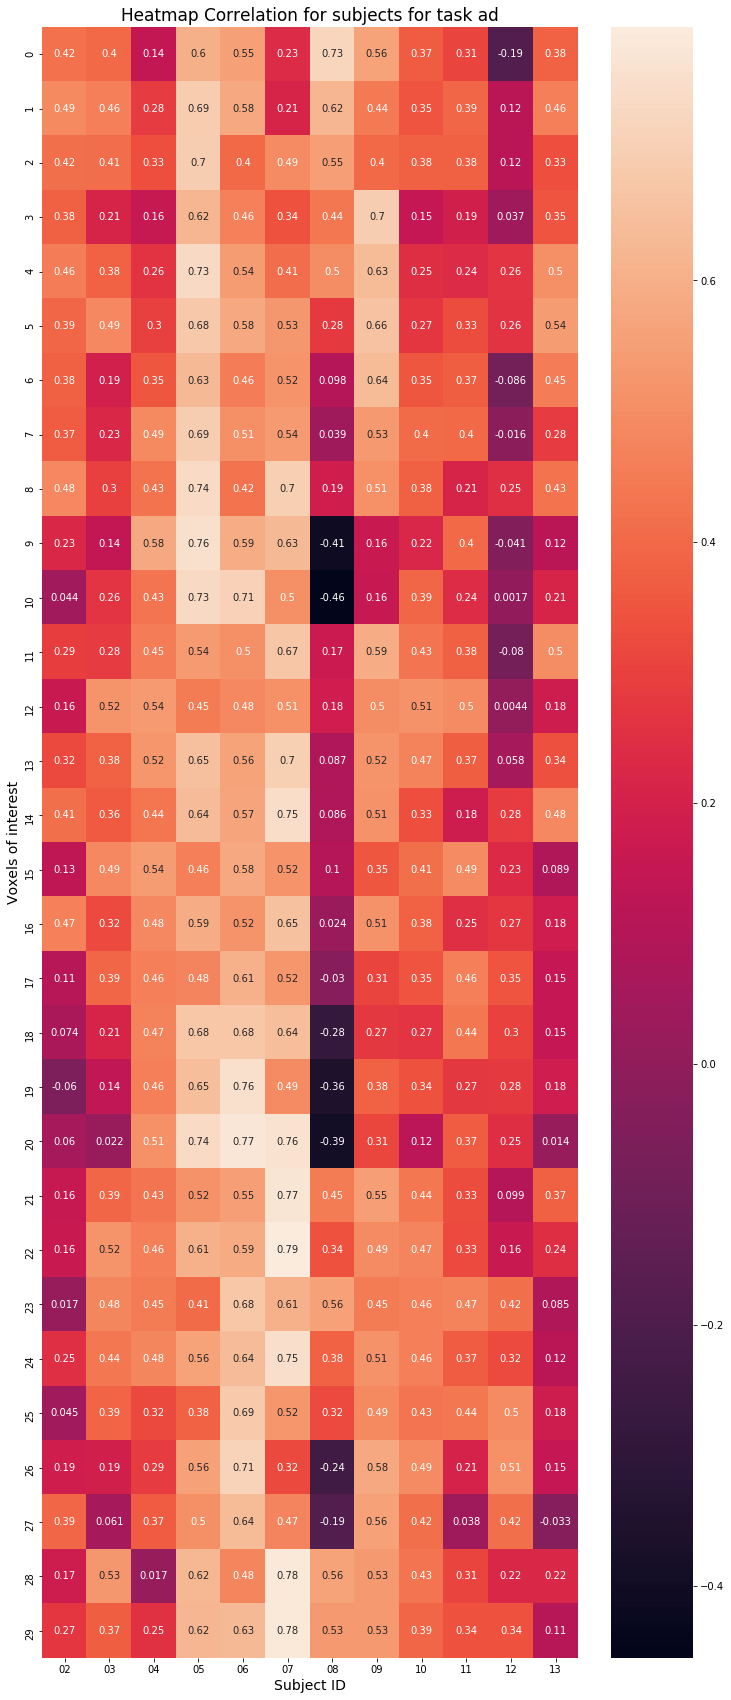

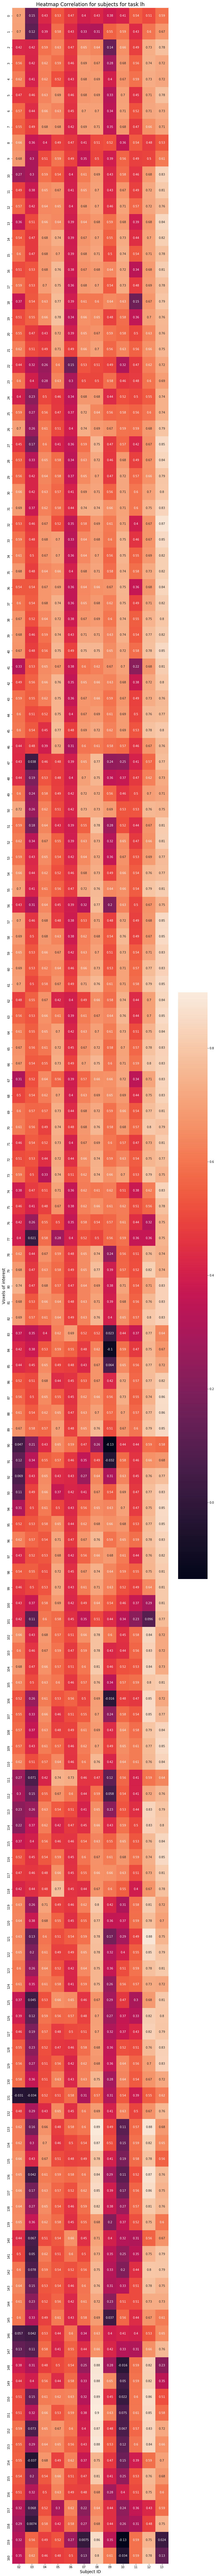

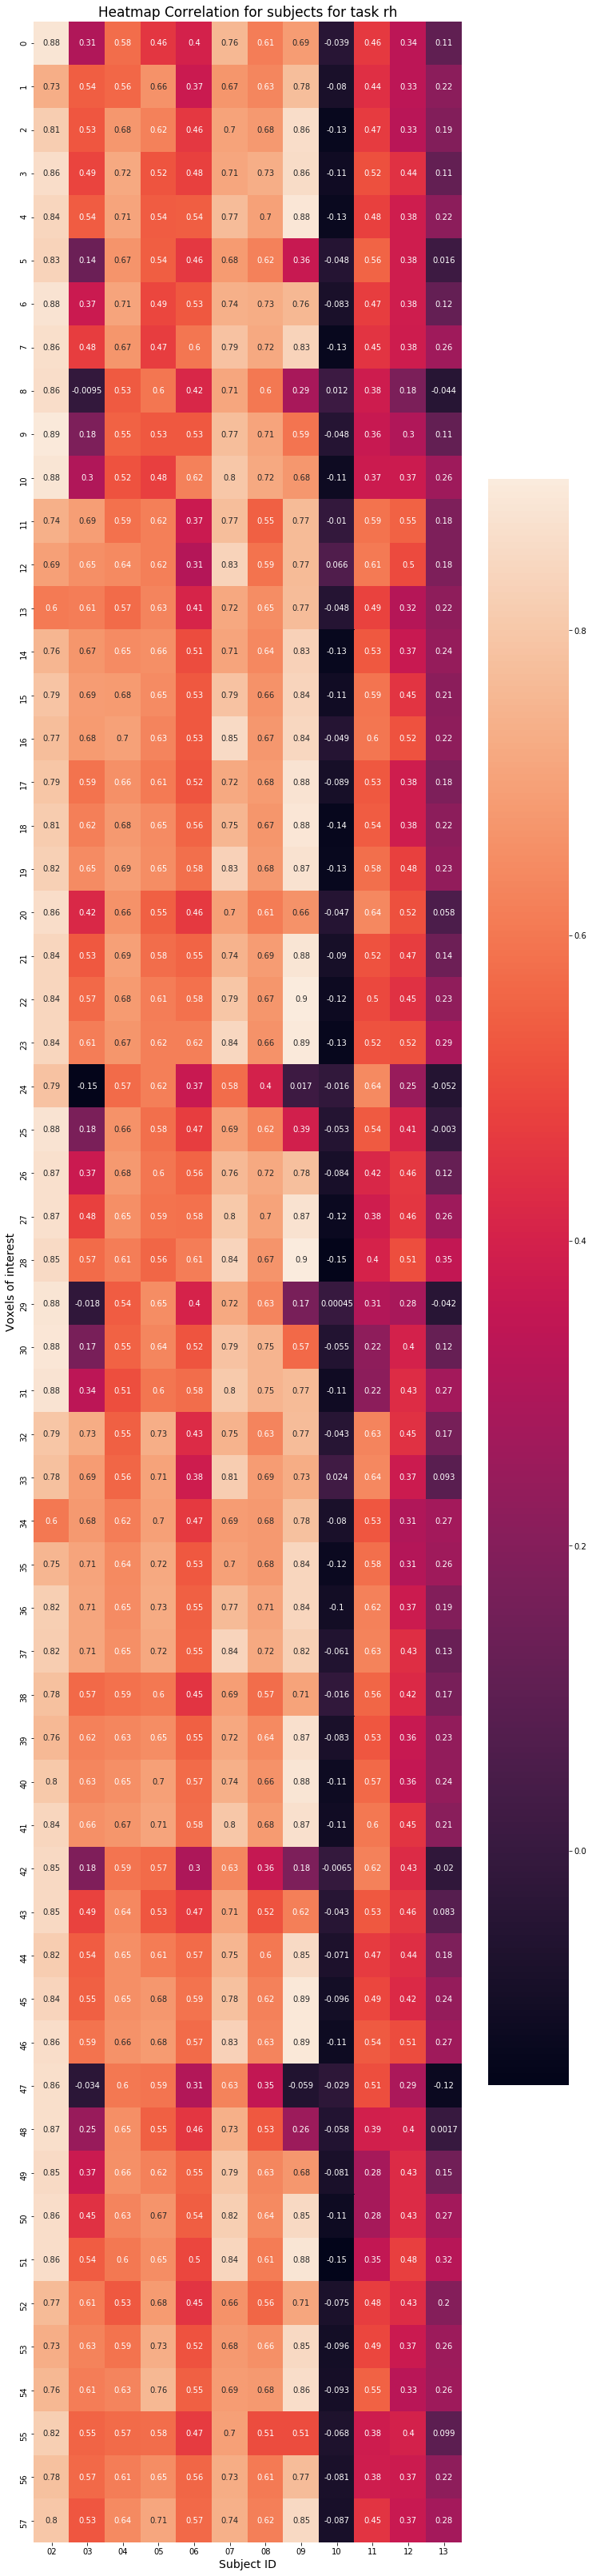

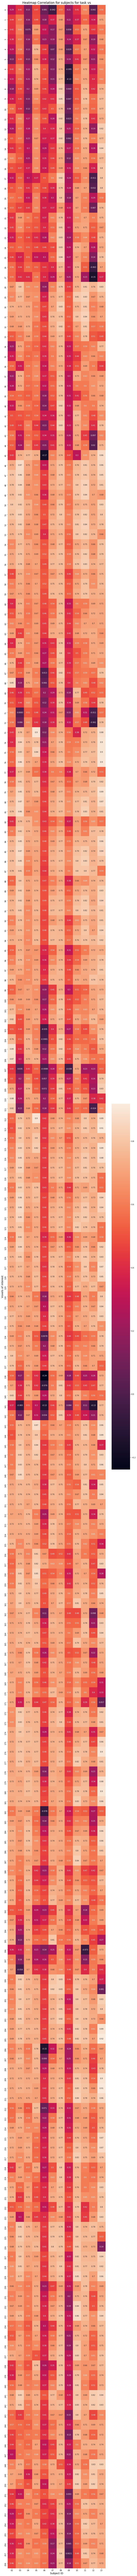

In [42]:
for task in tasks:
    corr_heat = get_corr_voxel(task, [0, 3.7, 1.6])
    plt.figure(figsize=(corr_heat.shape[1], corr_heat.shape[0]))
    sns.heatmap(get_corr_voxel(task, [0, 3.7, 1.6]), annot=True)
    plt.title(f'Heatmap Correlation for subjects for task {task}', fontsize=17)
    plt.ylabel('Voxels of interest', fontsize=14)
    plt.xlabel('Subject ID', fontsize=14)
    plt.show()

### 2.c Calculate the average CC across all voxels within an ROI for each of the parameter set and choose the optimal parameter set that showed the maximum average CC. The HRF obtained from the optimal parameter set is the estimated HRF of the pBOLD signal.

In [32]:
best_corr = [0, 0] # [idx, corr]
for comb in cases(params_one):
    corr_case = get_corr_voxel(task, comb).mean().mean()
    if best_corr[1] + .01 < corr_case:
        best_corr[1] = corr_case
        best_corr[0] = comb
        print(f'T0: {comb[0]:.3f}, n: {comb[1]:.3f}, l: {comb[2]:.3f} :: Corr: {best_corr[1]}')

T0: 0.000, n: 3.000, l: 2.000 :: Corr: 0.573960210681031
T0: 0.000, n: 3.200, l: 2.000 :: Corr: 0.5857027388717176


In [31]:
bestt = [0, 3.7, 1.6]

### 2.d Evaluate your results by comparing the estimated HRFs, estimated pBOLD signal, and average pBOLD signal.

In [80]:
best_params = [0, 3.7, 1.6] # had the best correlation
estimated_hrf = one_gamma(best_params)

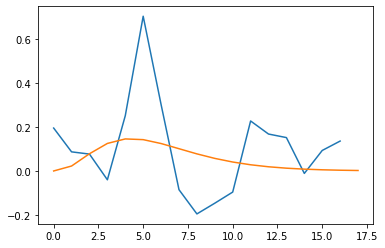

In [86]:
plt.plot(pBOLD('ad', '02')[8:25] / sum(pBOLD('ad', '02')))
plt.plot(estimated_hrf, )
plt.grid()
plt.legend()

## [3] Using a flexible model of HRF two gamma functions
Follow similar steps in [2] with difference in the adjustable parameters for the two gamma functions(i.e. $T_0$, $n_1$, $\lambda_1$, $a$, $n_2$, $\lambda_2$)

In [77]:
params_two = {
    'T0': [0],
    'n1' : [i * .1 for i in range(20, 50, 5)],
    'l1' : [i * .1 for i in range(20, 50, 5)],
    'a'  : [.3],
    'n2' : [i * .1 for i in range(30, 70, 5)],
    'l2' : [i * .1 for i in range(30, 70, 5)],
}

In [64]:
def two_gamma(params: list, t=None):

    t0, n1, l1, a, n2, l2 = params
    if t is None:
        t = np.arange(0, 18)
    
    term1 = (t - t0)**(n1-1) / (l1**n1 * math.gamma(n1)) * np.exp(-t/l1)
    term2 = (t - t0)**(n2-1) / (l2**n2 * math.gamma(n2)) * np.exp(-t/l2)
    return term1- a * term2

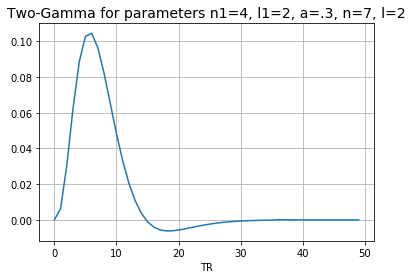

In [65]:
plt.plot(two_gamma([0, 4, 2, .3, 7, 2], t=np.arange(0, 50)))
plt.title('Two-Gamma for parameters n1=4, l1=2, a=.3, n=7, l=2', fontsize=14)
plt.xlabel('TR')
plt.grid()

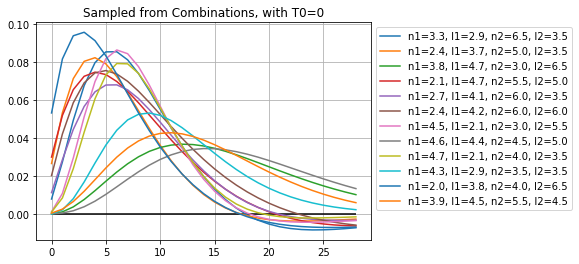

In [74]:
for i in range(12):
    
    sample = random.choice(cases(params_two))
    T0, n1, l1, a, n2, l2 = sample
    plt.plot(two_gamma(sample, t=np.arange(1, 30)), label=f'n1={n1:.1f}, l1={l1:.1f}, n2={n2:.1f}, l2={l2:.1f}')
    plt.legend(bbox_to_anchor=(1, 1))
    
plt.hlines(y=0, xmin=0, xmax=28)
plt.title('Sampled from Combinations, with T0=0')
plt.grid()

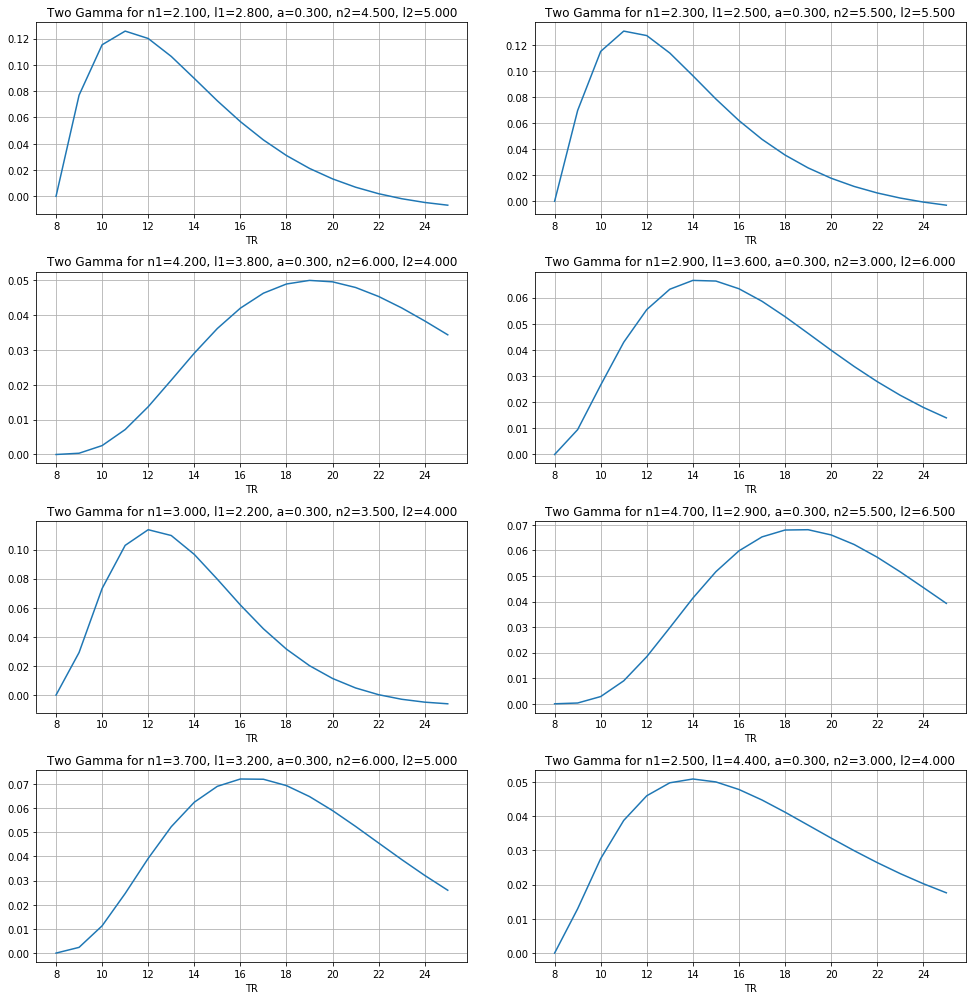

In [67]:
fig, axes = plt.subplots(4, 2, figsize=(14, 14))
for i in range(8):
    
    row, col = i // 2, i % 2
    sample = random.choice(cases(params_two))
    
    axes[row, col].plot(two_gamma(sample))
    T0, n1, l1, a, n2, l2 = sample
    axes[row, col].set_title(f'Two Gamma for n1={n1:.3f}, l1={l1:.3f}, a={a:.3f}, n2={n2:.3f}, l2={l2:.3f}')
    axes[row, col].set_xlabel('TR')
    axes[row, col].set_xticks(np.arange(0, 18, step=2))
    axes[row, col].set_xticklabels([f'{i+8}' for i in range(0, 18) if not i % 2])
    axes[row, col].grid()
    
fig.tight_layout()

In [78]:
best_corr = [0, 0] # [idx, corr]
for comb in cases(params_two):
    corr_case = get_corr_voxel(task, comb).mean().mean()
    if best_corr[1] + .01 < corr_case:
        best_corr[1] = corr_case
        best_corr[0] = comb
        print(f'n1: {comb[1]:.1f}, l1: {comb[2]:.1f}, n2: {comb[4]:.1f}, n3: {comb[-1]:.1f} :: Corr: {best_corr[1]}')

n1: 2.0, l1: 2.0, n2: 3.0, n3: 3.0 :: Corr: 0.27049383972992685
n1: 2.0, l1: 2.0, n2: 3.0, n3: 3.5 :: Corr: 0.2870718341322998
n1: 2.0, l1: 2.0, n2: 3.0, n3: 4.0 :: Corr: 0.2988220963543331
n1: 2.0, l1: 2.0, n2: 3.0, n3: 5.0 :: Corr: 0.3123876595369794
n1: 2.0, l1: 2.0, n2: 3.5, n3: 5.5 :: Corr: 0.32358923286954705
n1: 2.0, l1: 2.0, n2: 5.5, n3: 3.0 :: Corr: 0.33361611578577605
n1: 2.0, l1: 2.5, n2: 3.0, n3: 3.0 :: Corr: 0.3679045332090883
n1: 2.0, l1: 2.5, n2: 3.0, n3: 3.5 :: Corr: 0.3824940206496655
n1: 2.0, l1: 2.5, n2: 3.0, n3: 4.0 :: Corr: 0.3927941612221268
n1: 2.0, l1: 2.5, n2: 3.0, n3: 5.0 :: Corr: 0.4046071448446287
n1: 2.0, l1: 2.5, n2: 3.5, n3: 6.0 :: Corr: 0.4152479456900207
n1: 2.0, l1: 3.0, n2: 3.0, n3: 3.0 :: Corr: 0.42654523836082553
n1: 2.0, l1: 3.0, n2: 3.0, n3: 3.5 :: Corr: 0.439567591007683
n1: 2.0, l1: 3.0, n2: 3.0, n3: 4.5 :: Corr: 0.45412114191196123
n1: 2.0, l1: 3.0, n2: 3.5, n3: 5.5 :: Corr: 0.4649133687940534
n1: 2.0, l1: 3.5, n2: 3.0, n3: 4.0 :: Corr: 0.47862

n1: 3.5, l1: 2.0, n2: 3.0, n3: 3.0 :: Corr: 0.59601127882475

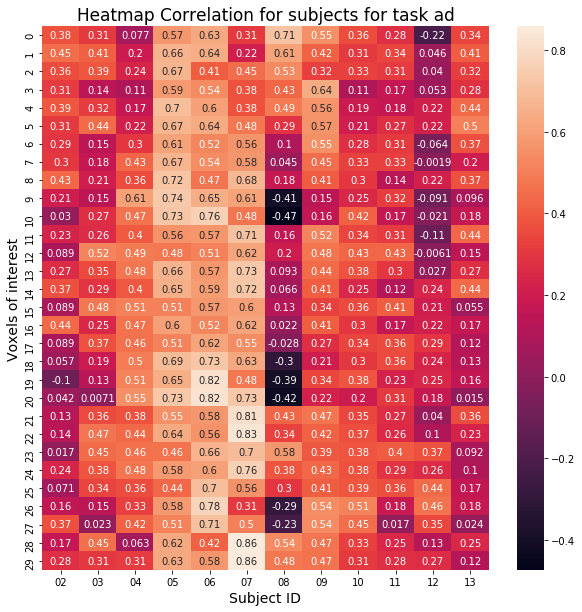

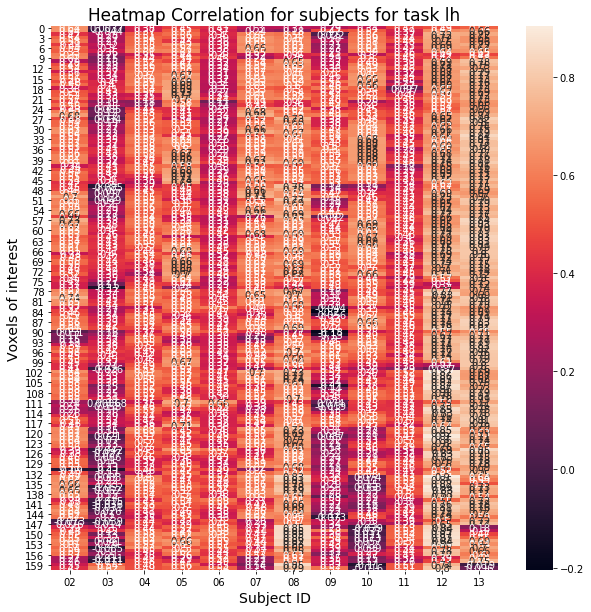

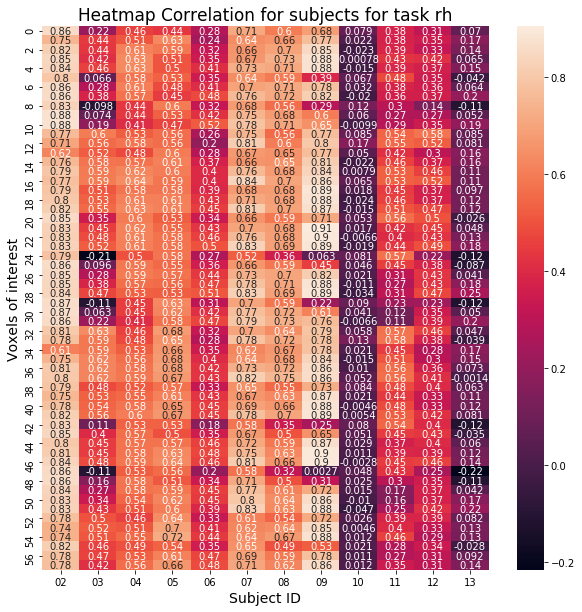

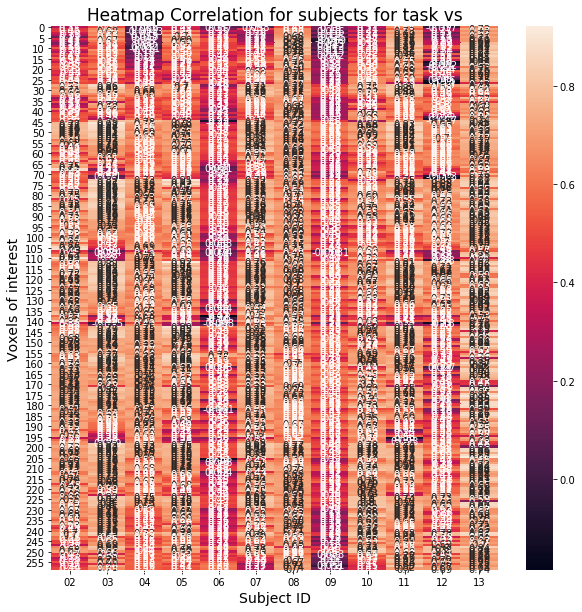

In [79]:
for task in tasks:
    plt.figure(figsize=(10, 10))
    sns.heatmap(get_corr_voxel(task, best_corr[0]), annot=True)
    plt.title(f'Heatmap Correlation for subjects for task {task}', fontsize=17)
    plt.ylabel('Voxels of interest', fontsize=14)
    plt.xlabel('Subject ID', fontsize=14)
    plt.show()

## [4] Based on the model with three fixed gamma function (Friston et al., 1998) using least-squares(LS) algorithm

### 4.a Study the LS algorithm and show your work

I got the idea of LS algorithm as a gradient method that checks its gradient with loss of Least squares, so as to say MSE(Mean Squared Loss). I made this algorithm by myself.

In [87]:
SSE = lambda true, pred: sum(np.square(true - pred)) / len(true)

In [88]:
def partial_difference_quotient(func, v, i, h=1e-9):
    
    w = [v_j + (h if j==i else 0) for j, v_j in enumerate(v)]
    return (func(w) - func(v)) / h

In [89]:
def gradient_estimate(func, v, h=1e-9):
    
    return [partial_difference_quotient(func, v, i, h) for i, _ in enumerate(v)]

In [90]:
def one_gamma_loss(params):
    
    task = 'ad'
    true = sum(pBOLD(task, zfill(sub_id)) for sub_id in sub_ids)[8:26]
    pred = one_gamma(params)
    return np.sum(np.square(true - pred)) / len(true)

In [109]:
class LeastSquares:
    
    def __init__(self, epochs, task, gamma_type, init_params, lr):
        
        self.epochs = epochs
        self.task   = task
        self.gamma = one_gamma if gamma_type == 1 else two_gamma
        self.init_params = init_params
        self.lr = lr
        self.true = sum(pBOLD(self.task, zfill(sub_id)) for sub_id in sub_ids)[8:26]
        self.true /= sum(self.true)
        
    def fit(self):
        
        params = self.init_params
        self.losses = []
        for e in range(self.epochs):
            
            pred = self.gamma(params)
            loss = SSE(self.true, pred)
            
            params = list(map(lambda w, g: w - g * self.lr, params, gradient_estimate(self.mse, params)))
            params = [0] + params[1:]
            
            if e % 100 == 0:
                self.losses.append(loss)
                print(f'{str(e):<5} th Epochs')
#                 print(f'Prediction:: {pred}')
                print(f'LOSS:: {loss}, Gradient:: {params}')
                print('\n')
            
        self.params = params
            
    def mse(self, params):
        
        true = self.true
        pred = self.gamma(params)
        return np.sum(np.square(true - pred)) / len(true)
            
        
    def plot_loss(self):
        
        plt.plot(self.losses)
        plt.title(f'MSE Loss among {self.epochs} epochs', fontsize=16)
        plt.xlabel('Epochs')
        plt.ylabel('MSE Loss')
        plt.grid()
        
    
    def plot_gamma(self, params=None):
        
        if params is None:
            params = self.params
            
        if len(params) == 3:
            T0, n, l = params
            ttl = f'Params of  T0={T0}, n={n:.3f}, l={l:.3f}'
            
        elif len(params) == 6:
            T0, n1, l1, a, n2, l2 = params
            ttl = f'Params of n1={n1:.3f}, l1={l1:.3f}, a={a:.3f}, n2={n2:.3f}, l2={l2:.3f}'
            
            
        plt.plot(self.gamma(params), label='Predicted HRF')
        plt.plot(self.true, label='Average pBOLD')
        plt.title(ttl)
        plt.xlabel('TR')
        plt.grid()
        plt.legend()

In [114]:
one = LeastSquares(100000, 'ad', 1, (0, 3.7, 1.6), 1e-2)
one.fit()

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  


0     th Epochs
LOSS:: 0.005286621729682512, Gradient:: [0, 3.6999990013110216, 1.5999832860173715]


100   th Epochs
LOSS:: 0.005283847295253611, Gradient:: [0, 3.699904829878216, 1.5983204285874952]


200   th Epochs
LOSS:: 0.005281130575037374, Gradient:: [0, 3.6998218634320033, 1.5966744105781017]


300   th Epochs
LOSS:: 0.005278470369453226, Gradient:: [0, 3.6997499855984555, 1.5950451202556515]


400   th Epochs
LOSS:: 0.0052758654910663085, Gradient:: [0, 3.699689079821509, 1.5934324435880982]


500   th Epochs
LOSS:: 0.005273314765412893, Gradient:: [0, 3.699639029553759, 1.59183626471326]


600   th Epochs
LOSS:: 0.005270817031340261, Gradient:: [0, 3.699599717692701, 1.5902564658954554]


700   th Epochs
LOSS:: 0.005268371141156601, Gradient:: [0, 3.699571027873085, 1.5886929276295836]


800   th Epochs
LOSS:: 0.005265975961772297, Gradient:: [0, 3.699552843599554, 1.5871455290661334]


900   th Epochs
LOSS:: 0.005263630373332162, Gradient:: [0, 3.699545048333386, 1.58561414

8500  th Epochs
LOSS:: 0.005168001308500692, Gradient:: [0, 3.7212817270923146, 1.5059243272013292]


8600  th Epochs
LOSS:: 0.005167279045389892, Gradient:: [0, 3.721770561039592, 1.5052291580360424]


8700  th Epochs
LOSS:: 0.005166562069869738, Gradient:: [0, 3.7222627494650276, 1.504540185511178]


8800  th Epochs
LOSS:: 0.005165850209554252, Gradient:: [0, 3.722758236189594, 1.5038573154312505]


8900  th Epochs
LOSS:: 0.005165143297010312, Gradient:: [0, 3.7232569657368377, 1.503180454121194]


9000  th Epochs
LOSS:: 0.005164441170446715, Gradient:: [0, 3.7237588835063375, 1.5025095098748524]


9100  th Epochs
LOSS:: 0.005163743672689759, Gradient:: [0, 3.7242639357476865, 1.5018443915325037]


9200  th Epochs
LOSS:: 0.005163050651704371, Gradient:: [0, 3.7247720691961996, 1.5011850092441503]


9300  th Epochs
LOSS:: 0.0051623619601570015, Gradient:: [0, 3.725283231437208, 1.5005312742179693]


9400  th Epochs
LOSS:: 0.005161677455196573, Gradient:: [0, 3.725797371148916, 1.49988

17700 th Epochs
LOSS:: 0.0051116217496527065, Gradient:: [0, 3.7751139726198963, 1.4589042714011413]


17800 th Epochs
LOSS:: 0.005111051657180698, Gradient:: [0, 3.7757562498669093, 1.4585073202659848]


17900 th Epochs
LOSS:: 0.005110481823767119, Gradient:: [0, 3.7763991544940154, 1.4581117130557997]


18000 th Epochs
LOSS:: 0.0051099122428117085, Gradient:: [0, 3.777042674158653, 1.457717427245202]


18100 th Epochs
LOSS:: 0.00510934290755176, Gradient:: [0, 3.777686797559105, 1.457324440855245]


18200 th Epochs
LOSS:: 0.005108773811557996, Gradient:: [0, 3.7783315133676214, 1.456932732305968]


18300 th Epochs
LOSS:: 0.00510820494864095, Gradient:: [0, 3.778976810395238, 1.456542280138842]


18400 th Epochs
LOSS:: 0.005107636313062225, Gradient:: [0, 3.7796226774009467, 1.4561530635111644]


18500 th Epochs
LOSS:: 0.005107067899071377, Gradient:: [0, 3.780269103586096, 1.4557650617623792]


18600 th Epochs
LOSS:: 0.005106499701183701, Gradient:: [0, 3.7809160784816265, 1.45537825

27100 th Epochs
LOSS:: 0.005058696988028793, Gradient:: [0, 3.8371406679710316, 1.4253788340096665]


27200 th Epochs
LOSS:: 0.005058138801927466, Gradient:: [0, 3.8378105285703104, 1.4250479680934038]


27300 th Epochs
LOSS:: 0.005057580698590761, Gradient:: [0, 3.8384804927759495, 1.424717437178268]


27400 th Epochs
LOSS:: 0.00505702267789713, Gradient:: [0, 3.8391505587491435, 1.4243872377687858]


27500 th Epochs
LOSS:: 0.0050564647397054125, Gradient:: [0, 3.839820724494958, 1.4240573659444853]


27600 th Epochs
LOSS:: 0.005055906883814963, Gradient:: [0, 3.8404909884868355, 1.4237278184874547]


27700 th Epochs
LOSS:: 0.005055349110192959, Gradient:: [0, 3.841161348530354, 1.4233985914338505]


27800 th Epochs
LOSS:: 0.005054791418826256, Gradient:: [0, 3.841831802760683, 1.4230696813662673]


27900 th Epochs
LOSS:: 0.0050542338093990296, Gradient:: [0, 3.842502349764022, 1.4227410849627078]


28000 th Epochs
LOSS:: 0.005053676281886219, Gradient:: [0, 3.843172987580137, 1.42241

35300 th Epochs
LOSS:: 0.005013196367007314, Gradient:: [0, 3.8922908172534916, 1.399124559916377]


35400 th Epochs
LOSS:: 0.005012644869443447, Gradient:: [0, 3.8929650557397135, 1.3988132730780567]


35500 th Epochs
LOSS:: 0.005012093454512713, Gradient:: [0, 3.8936393162916163, 1.39850216689384]


35600 th Epochs
LOSS:: 0.005011542122314102, Gradient:: [0, 3.894313598570935, 1.3981912408606565]


35700 th Epochs
LOSS:: 0.005010990872729958, Gradient:: [0, 3.894987902265411, 1.3978804940330818]


35800 th Epochs
LOSS:: 0.00501043970594214, Gradient:: [0, 3.8956622266291188, 1.3975699253442604]


35900 th Epochs
LOSS:: 0.005009888622056457, Gradient:: [0, 3.89633657137583, 1.3972595346467418]


36000 th Epochs
LOSS:: 0.005009337621010436, Gradient:: [0, 3.897010936254005, 1.3969493210471415]


36100 th Epochs
LOSS:: 0.005008786702972103, Gradient:: [0, 3.897685320595777, 1.3966392837648365]


36200 th Epochs
LOSS:: 0.005008235867815226, Gradient:: [0, 3.8983597242536963, 1.3963294220

43700 th Epochs
LOSS:: 0.004967163606709169, Gradient:: [0, 3.948973093851569, 1.3735558288516727]


43800 th Epochs
LOSS:: 0.004966619233981564, Gradient:: [0, 3.949648154882947, 1.3732580625695545]


43900 th Epochs
LOSS:: 0.004966074948343365, Gradient:: [0, 3.950323216894449, 1.3729604448231352]


44000 th Epochs
LOSS:: 0.004965530749804706, Gradient:: [0, 3.9509982798166816, 1.3726629754129198]


44100 th Epochs
LOSS:: 0.004964986638513013, Gradient:: [0, 3.951673343346064, 1.3723656541741085]


44200 th Epochs
LOSS:: 0.004964442614468608, Gradient:: [0, 3.95234840736117, 1.372068480829148]


44300 th Epochs
LOSS:: 0.00496389867773796, Gradient:: [0, 3.9530234719313824, 1.371771455681615]


44400 th Epochs
LOSS:: 0.004963354828295891, Gradient:: [0, 3.953698536787823, 1.3714745780983337]


44500 th Epochs
LOSS:: 0.004962811066256979, Gradient:: [0, 3.95437360167896, 1.3711778478364456]


44600 th Epochs
LOSS:: 0.004962267391583228, Gradient:: [0, 3.955048666708873, 1.3708812649913

52100 th Epochs
LOSS:: 0.0049217446392729415, Gradient:: [0, 4.005669346908515, 1.349047894758065]


52200 th Epochs
LOSS:: 0.004921207753304816, Gradient:: [0, 4.0063440567711455, 1.3487621467616202]


52300 th Epochs
LOSS:: 0.004920670958416538, Gradient:: [0, 4.007018757890765, 1.34847653743897]


52400 th Epochs
LOSS:: 0.004920134254732806, Gradient:: [0, 4.007693450102583, 1.3481910669115447]


52500 th Epochs
LOSS:: 0.004919597642052567, Gradient:: [0, 4.0083681336234385, 1.347905734988526]


52600 th Epochs
LOSS:: 0.004919061120725804, Gradient:: [0, 4.009042807863522, 1.3476205414530726]


52700 th Epochs
LOSS:: 0.004918524690756909, Gradient:: [0, 4.009717472822836, 1.3473354863398788]


52800 th Epochs
LOSS:: 0.004917988352115602, Gradient:: [0, 4.010392128405973, 1.3470505692586316]


52900 th Epochs
LOSS:: 0.004917452104688177, Gradient:: [0, 4.011066774873141, 1.346765790478213]


53000 th Epochs
LOSS:: 0.004916915948581261, Gradient:: [0, 4.011741411998819, 1.346481149825

60300 th Epochs
LOSS:: 0.0048780261447254995, Gradient:: [0, 4.060958272559808, 1.326070142453043]


60400 th Epochs
LOSS:: 0.004877496862246392, Gradient:: [0, 4.06163196192799, 1.3257955073727408]


60500 th Epochs
LOSS:: 0.004876967673979865, Gradient:: [0, 4.062305635449469, 1.3255210049554158]


60600 th Epochs
LOSS:: 0.004876438580024891, Gradient:: [0, 4.062979292759957, 1.3252466345245266]


60700 th Epochs
LOSS:: 0.004875909580411557, Gradient:: [0, 4.063652934006911, 1.3249723966351845]


60800 th Epochs
LOSS:: 0.004875380675299235, Gradient:: [0, 4.064326558765314, 1.3246982907843197]


60900 th Epochs
LOSS:: 0.004874851864481386, Gradient:: [0, 4.065000167399468, 1.3244243171367307]


61000 th Epochs
LOSS:: 0.004874323148069705, Gradient:: [0, 4.065673759692519, 1.324150475553642]


61100 th Epochs
LOSS:: 0.004873794526164212, Gradient:: [0, 4.0663473354883575, 1.3238767660523971]


61200 th Epochs
LOSS:: 0.004873265998891007, Gradient:: [0, 4.067020894466048, 1.32360318826

68700 th Epochs
LOSS:: 0.004833898138997672, Gradient:: [0, 4.117484915795836, 1.3034556510363933]


68800 th Epochs
LOSS:: 0.004833376886108364, Gradient:: [0, 4.118156989798191, 1.303191892386056]


68900 th Epochs
LOSS:: 0.004832855729821632, Gradient:: [0, 4.118829041760881, 1.3029282603618584]


69000 th Epochs
LOSS:: 0.0048323346704391215, Gradient:: [0, 4.1195010711721665, 1.3026647547469605]


69100 th Epochs
LOSS:: 0.004831813707987731, Gradient:: [0, 4.12017307792796, 1.3024013754112582]


69200 th Epochs
LOSS:: 0.0048312928423543105, Gradient:: [0, 4.120845062167046, 1.3021381223287307]


69300 th Epochs
LOSS:: 0.004830772073723162, Gradient:: [0, 4.121517023629216, 1.3018749954993765]


69400 th Epochs
LOSS:: 0.004830251401991168, Gradient:: [0, 4.122188962401203, 1.3016119948104405]


69500 th Epochs
LOSS:: 0.00482973082732735, Gradient:: [0, 4.1228608782401395, 1.301349120261922]


69600 th Epochs
LOSS:: 0.004829210349613288, Gradient:: [0, 4.123532771336853, 1.3010863719

77100 th Epochs
LOSS:: 0.004790452726402507, Gradient:: [0, 4.173854469152514, 1.2817342978306792]


77200 th Epochs
LOSS:: 0.00478993968919317, Gradient:: [0, 4.17452442310594, 1.2814809241111056]


77300 th Epochs
LOSS:: 0.004789426750531451, Gradient:: [0, 4.175194349208377, 1.2812276710068524]


77400 th Epochs
LOSS:: 0.004788913910846382, Gradient:: [0, 4.175864246948088, 1.280974538760785]


77500 th Epochs
LOSS:: 0.004788401169878408, Gradient:: [0, 4.176534116541909, 1.2807215269652419]


77600 th Epochs
LOSS:: 0.0047878885277079985, Gradient:: [0, 4.177203957842391, 1.2804686356115498]


77700 th Epochs
LOSS:: 0.004787375984235358, Gradient:: [0, 4.177873771118417, 1.2802158650119586]


77800 th Epochs
LOSS:: 0.004786863539611408, Gradient:: [0, 4.178543556005689, 1.2799632148021787]


77900 th Epochs
LOSS:: 0.0047863511937934495, Gradient:: [0, 4.179213312452175, 1.2797106847306723]


78000 th Epochs
LOSS:: 0.004785838946831547, Gradient:: [0, 4.179883040397154, 1.27945827491

85400 th Epochs
LOSS:: 0.00474820815754225, Gradient:: [0, 4.229359668816415, 1.2611088667801225]


85500 th Epochs
LOSS:: 0.004747703370777658, Gradient:: [0, 4.230027091461341, 1.2608652829551417]


85600 th Epochs
LOSS:: 0.004747198684103571, Gradient:: [0, 4.230694481077137, 1.2606218142897812]


85700 th Epochs
LOSS:: 0.00474669409750244, Gradient:: [0, 4.231361837707163, 1.2603784607927109]


85800 th Epochs
LOSS:: 0.004746189610810793, Gradient:: [0, 4.232029161481525, 1.260135222255765]


85900 th Epochs
LOSS:: 0.004745685224253586, Gradient:: [0, 4.232696452035932, 1.2598920985748598]


86000 th Epochs
LOSS:: 0.004745180937767972, Gradient:: [0, 4.233363709396407, 1.2596490896892822]


86100 th Epochs
LOSS:: 0.004744676751311638, Gradient:: [0, 4.234030933719077, 1.2594061957031144]


86200 th Epochs
LOSS:: 0.004744172664928433, Gradient:: [0, 4.234698124787095, 1.2591634164862502]


86300 th Epochs
LOSS:: 0.00474366867864382, Gradient:: [0, 4.23536528262648, 1.258920752021346

93600 th Epochs
LOSS:: 0.004707148794742164, Gradient:: [0, 4.283974285352233, 1.2415115614655814]


93700 th Epochs
LOSS:: 0.004706652244993104, Gradient:: [0, 4.284638833777203, 1.2412772016770663]


93800 th Epochs
LOSS:: 0.004706155796164361, Gradient:: [0, 4.285303344905618, 1.241042951748589]


93900 th Epochs
LOSS:: 0.004705659448138613, Gradient:: [0, 4.285967818832888, 1.240808811437288]


94000 th Epochs
LOSS:: 0.004705163200926007, Gradient:: [0, 4.286632255524317, 1.24057478063908]


94100 th Epochs
LOSS:: 0.00470466705461172, Gradient:: [0, 4.287296654849807, 1.2403408596054997]


94200 th Epochs
LOSS:: 0.004704171009034182, Gradient:: [0, 4.287961017147622, 1.2401070483452217]


94300 th Epochs
LOSS:: 0.004703675064446404, Gradient:: [0, 4.288625341741222, 1.2398733463811977]


94400 th Epochs
LOSS:: 0.004703179220658871, Gradient:: [0, 4.289289629046942, 1.2396397539476118]


94500 th Epochs
LOSS:: 0.004702683477724557, Gradient:: [0, 4.28995387885661, 1.2394062706801752

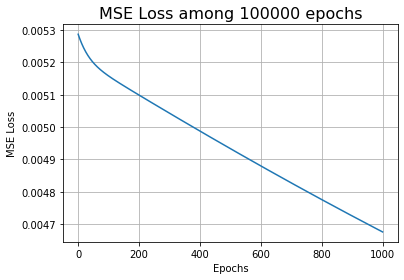

In [115]:
one.plot_loss()

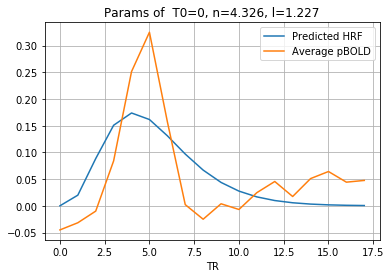

In [116]:
one.plot_gamma()

In [120]:
two = LeastSquares(100000, 'ad', 2, (0, 3.5, 2, .3, 3, 3), 1e-2)
two.fit()

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


0     th Epochs
LOSS:: 0.006513540099442697, Gradient:: [0, 3.499986526654297, 1.9999715689577573, 0.2999746424714231, 3.0000037946208673, 3.000003407924984]


100   th Epochs
LOSS:: 0.006497067874653508, Gradient:: [0, 3.4986468971618914, 1.9971354590604797, 0.29744942965479443, 3.0003799279033747, 3.00034118374792]


200   th Epochs
LOSS:: 0.006480827775248074, Gradient:: [0, 3.497322505575906, 1.994313214452327, 0.2949449403045115, 3.0007495392414367, 3.0006730537221293]


300   th Epochs
LOSS:: 0.006464816696422837, Gradient:: [0, 3.4960133140186604, 1.9915048531137087, 0.2924609525147473, 3.001112732093965, 3.000999117455434]


400   th Epochs
LOSS:: 0.006449031580523411, Gradient:: [0, 3.494719283216008, 1.9887103923398173, 0.28999724733737825, 3.0014696081331023, 3.001319473219919]


500   th Epochs
LOSS:: 0.006433469414903911, Gradient:: [0, 3.493440373364722, 1.985929848220212, 0.2875536086345329, 3.001820267504433, 3.001634216997833]


600   th Epochs
LOSS:: 0.006418127235030

5300  th Epochs
LOSS:: 0.005898792854480715, Gradient:: [0, 3.448862872403398, 1.8689292023037363, 0.19025922314360427, 3.0129792742872397, 3.011682706911216]


5400  th Epochs
LOSS:: 0.005891189511230219, Gradient:: [0, 3.4482603806142995, 1.8668314317787391, 0.18858542794394056, 3.013121855373066, 3.011812669462355]


5500  th Epochs
LOSS:: 0.005883699353085634, Gradient:: [0, 3.4476700890920418, 1.8647471618085816, 0.18692385879777978, 3.0132617158920656, 3.0119402467600405]


5600  th Epochs
LOSS:: 0.005876320769294096, Gradient:: [0, 3.4470919242583236, 1.862676355773253, 0.1852744049950697, 3.013398902300133, 3.012065479561599]


5700  th Epochs
LOSS:: 0.005869052169701616, Gradient:: [0, 3.4465258121011724, 1.8606189772348858, 0.1836369573870092, 3.0135334598388566, 3.0121884082253767]


5800  th Epochs
LOSS:: 0.00586189197958441, Gradient:: [0, 3.445971678417792, 1.8585749875958826, 0.1820114081952287, 3.0136654335503312, 3.012309072224996]


5900  th Epochs
LOSS:: 0.0058548386

10600 th Epochs
LOSS:: 0.005618925531840683, Gradient:: [0, 3.4319520626370665, 1.775241009570507, 0.11615973896481585, 3.017689211501736, 3.0160716632449587]


10700 th Epochs
LOSS:: 0.0056154833732224635, Gradient:: [0, 3.4318902550207535, 1.773788771544491, 0.11500889442362355, 3.017737307213177, 3.0161184864413215]


10800 th Epochs
LOSS:: 0.005612090774484357, Gradient:: [0, 3.4318365613653325, 1.7723470234260308, 0.11386592856277827, 3.017784354813369, 3.0161643728783334]


10900 th Epochs
LOSS:: 0.0056087469080192505, Gradient:: [0, 3.43179090698228, 1.7709156943256485, 0.11273078192463287, 3.0178303738179473, 3.016209339183319]


11000 th Epochs
LOSS:: 0.005605450959900269, Gradient:: [0, 3.431753217521354, 1.7694947137875507, 0.11160339613574238, 3.017875383733881, 3.0162534021310523]


11100 th Epochs
LOSS:: 0.005602202125645276, Gradient:: [0, 3.4317234182766865, 1.768084010020208, 0.11048371297011333, 3.0179194034956764, 3.0162965773600696]


11200 th Epochs
LOSS:: 0.005598



15700 th Epochs
LOSS:: 0.005492059429178727, Gradient:: [0, 3.437673236735747, 1.7130607544069623, 0.06641549816365472, 3.0191437950733433, 3.017553343934531]


15800 th Epochs
LOSS:: 0.005490310751047918, Gradient:: [0, 3.437937287747704, 1.71205252515167, 0.06560196859008688, 3.019157772304169, 3.0175688819220956]


15900 th Epochs
LOSS:: 0.005488582326582862, Gradient:: [0, 3.438206116309546, 1.7110511959238024, 0.06479393322403854, 3.0191713742015525, 3.017584058453998]


16000 th Epochs
LOSS:: 0.00548687379436079, Gradient:: [0, 3.4384796683672874, 1.710056701280917, 0.0639913553414137, 3.0191846089360412, 3.0175988801915783]


16100 th Epochs
LOSS:: 0.005485184799740219, Gradient:: [0, 3.438757890170522, 1.7090689764310891, 0.0631941987732279, 3.0191974844179703, 3.0176133541171026]


16200 th Epochs
LOSS:: 0.005483514994432017, Gradient:: [0, 3.4390407287407947, 1.7080879571288379, 0.062402427532642635, 3.0192100083408384, 3.0176274870653814]


16300 th Epochs
LOSS:: 0.0054818

20900 th Epochs
LOSS:: 0.005421485997767732, Gradient:: [0, 3.4566661486317223, 1.668442205620822, 0.030660346823965512, 3.0195171676908394, 3.0180080661231927]


21000 th Epochs
LOSS:: 0.005420427918604712, Gradient:: [0, 3.4571168345959604, 1.667714726502209, 0.030089688268833126, 3.0195196625874896, 3.0180118626609262]


21100 th Epochs
LOSS:: 0.005419377834608204, Gradient:: [0, 3.4575700712715727, 1.666991274197202, 0.02952294710094866, 3.019522052862969, 3.0180155379067912]


21200 th Epochs
LOSS:: 0.005418335606940619, Gradient:: [0, 3.4580258263927077, 1.6662718044356564, 0.0289600980106966, 3.01952434160508, 3.0180190942807323]


21300 th Epochs
LOSS:: 0.005417301099616082, Gradient:: [0, 3.458484068569545, 1.6655562737974432, 0.02840111641704529, 3.019526531658774, 3.018022535052702]


21400 th Epochs
LOSS:: 0.005416274178829213, Gradient:: [0, 3.458944766568386, 1.6648446386542677, 0.027845977851720105, 3.0195286261465495, 3.0180258624951906]


21500 th Epochs
LOSS:: 0.00541

26200 th Epochs
LOSS:: 0.005373805685956125, Gradient:: [0, 3.483414853427909, 1.6345134937148522, 0.0052734253787098395, 3.019561352416099, 3.018094987062325]


26300 th Epochs
LOSS:: 0.005373028359106798, Gradient:: [0, 3.4839642339776438, 1.6339475460615271, 0.0048794899735801756, 3.019561347142541, 3.0180952472881937]


26400 th Epochs
LOSS:: 0.005372254299790912, Gradient:: [0, 3.484514899523791, 1.6333838004922048, 0.0044883478895804685, 3.019561336421948, 3.0180954819962746]


26500 th Epochs
LOSS:: 0.005371483455696112, Gradient:: [0, 3.485066833603828, 1.6328222318100245, 0.004099981614677228, 3.01956132141659, 3.01809569237486]


26600 th Epochs
LOSS:: 0.005370715775187647, Gradient:: [0, 3.485620019581756, 1.6322628148701699, 0.0037143733072395047, 3.0195613029331083, 3.01809587944744]


26700 th Epochs
LOSS:: 0.005369951207614949, Gradient:: [0, 3.486174441073111, 1.6317055247012955, 0.0033315052991086946, 3.0195612818302, 3.0180960440033098]


26800 th Epochs
LOSS:: 0.0053

31600 th Epochs
LOSS:: 0.005335450468975687, Gradient:: [0, 3.514566067622892, 1.6065587658507623, -0.01241068982647281, 3.0195725836403446, 3.018093633284166]


31700 th Epochs
LOSS:: 0.0053347928955621935, Gradient:: [0, 3.515165523246921, 1.6060818698627897, -0.012676744331288903, 3.019573298554582, 3.0180936378031182]


31800 th Epochs
LOSS:: 0.005334136737078211, Gradient:: [0, 3.5157656142828095, 1.6056061612149746, -0.012940825683560864, 3.0195740399407, 3.0180936528084787]


31900 th Epochs
LOSS:: 0.005333481972443469, Gradient:: [0, 3.5163663326120544, 1.6051316263504527, -0.01320294683299944, 3.01957480759053, 3.0180936785517725]


32000 th Epochs
LOSS:: 0.00533282858129625, Gradient:: [0, 3.5169676700294157, 1.604658252362879, -0.013463120425738773, 3.0195756017642834, 3.0180937152498464]


32100 th Epochs
LOSS:: 0.005332176543545407, Gradient:: [0, 3.5175696186332255, 1.6041860266234693, -0.013721359185975557, 3.019576422644103, 3.0180937632756653]


32200 th Epochs
LOSS:: 

36900 th Epochs
LOSS:: 0.005302143766920779, Gradient:: [0, 3.5470517035229308, 1.582654166700177, -0.024070126133529934, 3.019650790256811, 3.018114631764848]


37000 th Epochs
LOSS:: 0.005301538853873396, Gradient:: [0, 3.5476758969455746, 1.5822254176673722, -0.024247491573573254, 3.019653112175511, 3.018115532216432]


37100 th Epochs
LOSS:: 0.00530093460207423, Gradient:: [0, 3.548300420451401, 1.5817973463997037, -0.024423462408698915, 3.0196554666202764, 3.01811645411787]


37200 th Epochs
LOSS:: 0.005300331002513886, Gradient:: [0, 3.5489252702673877, 1.5813699465220608, -0.024598047702837078, 3.0196578536258, 3.0181173974604913]


37300 th Epochs
LOSS:: 0.005299728046149966, Gradient:: [0, 3.5495504424383633, 1.5809432110868797, -0.024771256563285993, 3.019660273018613, 3.0181183621228693]


37400 th Epochs
LOSS:: 0.0052991257242841015, Gradient:: [0, 3.550175933269368, 1.580517134083339, -0.024943098305510725, 3.019662724911468, 3.0181193483738804]


37500 th Epochs
LOSS:: 0.



42000 th Epochs
LOSS:: 0.005271976469243846, Gradient:: [0, 3.5792382977201287, 1.5615333982413588, -0.031515008292204716, 3.0198103689611644, 3.018188935262182]


42100 th Epochs
LOSS:: 0.005271396056711981, Gradient:: [0, 3.579875386070953, 1.5611323212572346, -0.031631823608305465, 3.0198143225000513, 3.0181909848119477]


42200 th Epochs
LOSS:: 0.005270815978182204, Gradient:: [0, 3.580512664035727, 1.5607316743977964, -0.03174764517938938, 3.019818306760887, 3.0181930572687357]


42300 th Epochs
LOSS:: 0.005270236229180705, Gradient:: [0, 3.5811501301919773, 1.560331454453805, -0.03186247953669036, 3.0198223219778653, 3.0181951527973467]


42400 th Epochs
LOSS:: 0.005269656805699444, Gradient:: [0, 3.581787782145784, 1.559931657712954, -0.03197633334154654, 3.0198263678474087, 3.0181972712676766]


42500 th Epochs
LOSS:: 0.005269077703518736, Gradient:: [0, 3.5824256183966137, 1.559532281200191, -0.032089213194580746, 3.019830444291453, 3.0181994126883973]


42600 th Epochs
LOSS

47200 th Epochs
LOSS:: 0.005242158056758994, Gradient:: [0, 3.6125834638189276, 1.541183666957612, -0.036407331756952155, 3.0200551956894985, 3.018325425222148]


47300 th Epochs
LOSS:: 0.005241590498556959, Gradient:: [0, 3.613228433339428, 1.5408013137893892, -0.036480387797336034, 3.0200606520540276, 3.018328632682487]


47400 th Epochs
LOSS:: 0.005241023117501321, Gradient:: [0, 3.613873523128308, 1.5404192627666284, -0.03655274377271395, 3.0200661351159486, 3.0183318612283925]


47500 th Epochs
LOSS:: 0.005240455911580436, Gradient:: [0, 3.614518732231465, 1.5400375121112364, -0.036624404384186515, 3.0200716445977074, 3.0183351108772047]


47600 th Epochs
LOSS:: 0.0052398888787551405, Gradient:: [0, 3.6151640597555232, 1.539656059897671, -0.036695374280812654, 3.020077180707474, 3.018338381793729]


47700 th Epochs
LOSS:: 0.005239322017059841, Gradient:: [0, 3.615809504937202, 1.5392749046514156, -0.03676565801624149, 3.0200827432023845, 3.018341673821837]


47800 th Epochs
LOSS::

52500 th Epochs
LOSS:: 0.005212282142141976, Gradient:: [0, 3.6469142746953347, 1.5213007106345657, -0.03941669019647848, 3.02037919842385, 3.0185234668485452]


52600 th Epochs
LOSS:: 0.005211721792210643, Gradient:: [0, 3.647564596601032, 1.5209324439066887, -0.03945848136769653, 3.020385953064099, 3.0185277272600137]


52700 th Epochs
LOSS:: 0.005211161545547313, Gradient:: [0, 3.648215003326037, 1.5205644129277325, -0.03949978452650632, 3.020392729917482, 3.0185320061202665]


52800 th Epochs
LOSS:: 0.005210601401150533, Gradient:: [0, 3.64886549447136, 1.5201966167175762, -0.039540603038271394, 3.020399528845223, 3.0185363032124632]


52900 th Epochs
LOSS:: 0.005210041358130488, Gradient:: [0, 3.6495160695599522, 1.5198290543047783, -0.03958094020763997, 3.0204063496825158, 3.018540618527929]


53000 th Epochs
LOSS:: 0.005209481415654669, Gradient:: [0, 3.6501667280887444, 1.5194617249520799, -0.03962079944334368, 3.020413192576816, 3.018544952127382]


53100 th Epochs
LOSS:: 0.00

57900 th Epochs
LOSS:: 0.005182152344437787, Gradient:: [0, 3.682142765540289, 1.501732583758765, -0.04105128500841465, 3.0207736903453766, 3.018778408046916]


58000 th Epochs
LOSS:: 0.005181596564687539, Gradient:: [0, 3.682797099566489, 1.5013760031430363, -0.04107099223038008, 3.0207815283117654, 3.018783579283618]


58100 th Epochs
LOSS:: 0.0051810408553094505, Gradient:: [0, 3.68345149850604, 1.5010196227924584, -0.04109036331497756, 3.0207893840677427, 3.0187887656991506]


58200 th Epochs
LOSS:: 0.005180485215761195, Gradient:: [0, 3.684105962315575, 1.500663442186616, -0.04110940033520166, 3.020797257812802, 3.018793967510354]


58300 th Epochs
LOSS:: 0.005179929645561452, Gradient:: [0, 3.684760490734887, 1.5003074605622295, -0.041128105910484825, 3.0208051491566317, 3.0187991843529387]


58400 th Epochs
LOSS:: 0.00517937414453077, Gradient:: [0, 3.6854150833910087, 1.4999516778152162, -0.0411464822612731, 3.020813058316072, 3.018804416504456]


58500 th Epochs
LOSS:: 0.00517

63400 th Epochs
LOSS:: 0.005151680881901483, Gradient:: [0, 3.7182211318417258, 1.4824069943834504, -0.04169196802720515, 3.0212295499836177, 3.019084183122326]


63500 th Epochs
LOSS:: 0.005151128553865086, Gradient:: [0, 3.7188786799288853, 1.4820608318577224, -0.04169626349743466, 3.0212382704558784, 3.0190901186695176]


63600 th Epochs
LOSS:: 0.005150576283228011, Gradient:: [0, 3.7195362803960226, 1.4817148496825214, -0.04170033001885981, 3.0212470052396094, 3.0190960668628444]


63700 th Epochs
LOSS:: 0.005150024069860076, Gradient:: [0, 3.720193932965577, 1.4813690473461048, -0.041704169204773434, 3.0212557541526626, 3.0191020275375062]


63800 th Epochs
LOSS:: 0.005149471913710645, Gradient:: [0, 3.720851637255914, 1.4810234244147893, -0.04170778285061433, 3.0212645171863644, 3.019108000650135]


63900 th Epochs
LOSS:: 0.0051489198145652695, Gradient:: [0, 3.7215093932583576, 1.4806779806890817, -0.04171117256100171, 3.021273294115201, 3.019113985862461]


64000 th Epochs
LOSS

68800 th Epochs
LOSS:: 0.005121935092139134, Gradient:: [0, 3.7537990338984604, 1.4639657834033084, -0.041633154847184606, 3.021719302545034, 3.0194214316326775]


68900 th Epochs
LOSS:: 0.005121385751627642, Gradient:: [0, 3.7544591488385994, 1.4636290029733765, -0.041627148766135436, 3.0217287058564968, 3.019427976059135]


69000 th Epochs
LOSS:: 0.00512083646535961, Gradient:: [0, 3.7551193067738615, 1.463292390750906, -0.04162098701100153, 3.021738120365601, 3.019434530581685]


69100 th Epochs
LOSS:: 0.005120287233341469, Gradient:: [0, 3.755779507470057, 1.462955946414973, -0.0416146704838391, 3.021747545898874, 3.0194410953391047]


69200 th Epochs
LOSS:: 0.005119738055609235, Gradient:: [0, 3.756439750692997, 1.4626196696880225, -0.041608200364260106, 3.0217569824042725, 3.0194476698456705]


69300 th Epochs
LOSS:: 0.005119188931961644, Gradient:: [0, 3.757100036442684, 1.4622835602491313, -0.041601577892591834, 3.021766430098636, 3.0194542545784273]


69400 th Epochs
LOSS:: 0.

74400 th Epochs
LOSS:: 0.005091255789838163, Gradient:: [0, 3.7908273562425308, 1.4453602205490306, -0.04108536015563241, 3.0222616464405285, 3.019802348232866]


74500 th Epochs
LOSS:: 0.005090709507354569, Gradient:: [0, 3.7914896433947343, 1.4450326003958016, -0.041072162162586745, 3.0222715976297057, 3.0198093972730295]


74600 th Epochs
LOSS:: 0.005090163280354108, Gradient:: [0, 3.7921519651893663, 1.4447051396116188, -0.04105886075400106, 3.022281557397092, 3.019816454206188]


74700 th Epochs
LOSS:: 0.005089617108959743, Gradient:: [0, 3.792814321504995, 1.4443778383439332, -0.04104545647631325, 3.022291525499824, 3.0198235191017235]


74800 th Epochs
LOSS:: 0.005089070993130702, Gradient:: [0, 3.793476712185494, 1.4440506961243673, -0.04103195055250336, 3.022301501868512, 3.0198305918295394]


74900 th Epochs
LOSS:: 0.005088524932818095, Gradient:: [0, 3.794139137326275, 1.4437237130743559, -0.04101834336421056, 3.0223114866766347, 3.0198376724243245]


75000 th Epochs
LOSS:: 

79600 th Epochs
LOSS:: 0.005062923794981654, Gradient:: [0, 3.8253092990384268, 1.4285327025502101, -0.04027750129769775, 3.0227894400392863, 3.0201787166568472]


79700 th Epochs
LOSS:: 0.00506238046735481, Gradient:: [0, 3.825973212251027, 1.4282132146592055, -0.04025983385033155, 3.022799778375377, 3.02018613614721]


79800 th Epochs
LOSS:: 0.005061837198226575, Gradient:: [0, 3.826637153028383, 1.4278938801264311, -0.04024209658901906, 3.022810123199332, 3.0201935620213565]


79900 th Epochs
LOSS:: 0.005061293987571865, Gradient:: [0, 3.8273011216046835, 1.4275746991600509, -0.04022429018162882, 3.0228204743203326, 3.0202009940624435]


80000 th Epochs
LOSS:: 0.005060750835436182, Gradient:: [0, 3.8279651178064578, 1.4272556715779214, -0.04020641503582084, 3.022830831989913, 3.0202084323745573]


80100 th Epochs
LOSS:: 0.005060207741808209, Gradient:: [0, 3.8286291413908407, 1.4269367968075832, -0.040188471689359406, 3.0228411958351136, 3.0202158769576952]


80200 th Epochs
LOSS:: 

LOSS:: 0.005035289923200221, Gradient:: [0, 3.8592017185343437, 1.412432373736988, -0.039297840613525536, 3.0233241825326402, 3.020564568701417]


84800 th Epochs
LOSS:: 0.005034749659107838, Gradient:: [0, 3.8598668911561873, 1.412120585329394, -0.039277230433296395, 3.023334805606241, 3.020572274507896]


84900 th Epochs
LOSS:: 0.005034209456856197, Gradient:: [0, 3.860532085349319, 1.4118089454488247, -0.039256573536964046, 3.0233454335891112, 3.0205799851802757]


85000 th Epochs
LOSS:: 0.0050336693166102625, Gradient:: [0, 3.8611973008275053, 1.4114974540432386, -0.03923587058372341, 3.023356066056241, 3.0205877008313107]


85100 th Epochs
LOSS:: 0.005033129238159655, Gradient:: [0, 3.8618625379203486, 1.41118611098253, -0.03921512189449833, 3.023366703328552, 3.020595421304881]


85200 th Epochs
LOSS:: 0.005032589222045119, Gradient:: [0, 3.8625277958038513, 1.410874916223332, -0.03919432780755988, 3.0233773451458417, 3.0206031465402603]


85300 th Epochs
LOSS:: 0.005032049267897

89800 th Epochs
LOSS:: 0.005007816796925881, Gradient:: [0, 3.8931505292674355, 1.3967187451442196, -0.03819473018066594, 3.0238714044445087, 3.0209633397436577]


89900 th Epochs
LOSS:: 0.005007279777783364, Gradient:: [0, 3.893816650809041, 1.3964144223879897, -0.03817218321637034, 3.0238822327966135, 3.0209712663891057]


90000 th Epochs
LOSS:: 0.005006742824138311, Gradient:: [0, 3.8944827879631596, 1.3961102439520794, -0.038149606267379454, 3.0238930644013227, 3.0209791965907393]


90100 th Epochs
LOSS:: 0.005006205936028676, Gradient:: [0, 3.8951489405823376, 1.3958062096196477, -0.038126999446450316, 3.0239038993106813, 3.0209871306000897]


90200 th Epochs
LOSS:: 0.0050056691135035416, Gradient:: [0, 3.8958151087186152, 1.3955023194600835, -0.03810436303113868, 3.023914737498668, 3.020995068252363]


90300 th Epochs
LOSS:: 0.005005132356638101, Gradient:: [0, 3.89648129212046, 1.3951985732565473, -0.03808169747247264, 3.0239255787918085, 3.0210030096342892]


90400 th Epochs
LO


95100 th Epochs
LOSS:: 0.004979446613250433, Gradient:: [0, 3.9284739093564323, 1.3807865568585527, -0.036964092201991205, 3.02444927692527, 3.021388109953985]


95200 th Epochs
LOSS:: 0.004978913158797779, Gradient:: [0, 3.9291407071539637, 1.380489770998775, -0.036940282124817425, 3.0244602465185633, 3.021396206359477]


95300 th Epochs
LOSS:: 0.004978379773369155, Gradient:: [0, 3.929807514856768, 1.3801931251745505, -0.0369164539111097, 3.0244712179506568, 3.021404305280314]


95400 th Epochs
LOSS:: 0.004977846457335272, Gradient:: [0, 3.9304743319704465, 1.379896619585371, -0.03689260780372933, 3.0244821914123783, 3.021412406915995]


95500 th Epochs
LOSS:: 0.004977313210414277, Gradient:: [0, 3.9311411588592935, 1.3796002538756196, -0.03686874386339162, 3.0244931669384236, 3.0214205111277437]


95600 th Epochs
LOSS:: 0.004976780032635557, Gradient:: [0, 3.9318079954972873, 1.3793040281320312, -0.036844862350305096, 3.02450414463287, 3.0214286181237213]


95700 th Epochs
LOSS:: 0

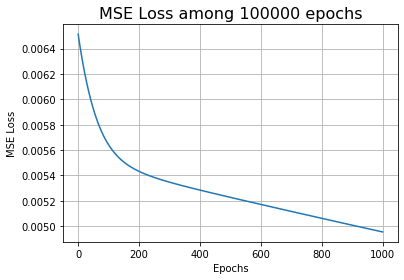

In [121]:
two.plot_loss()

In [124]:
two_gamma(two.params)

array([0.        , 0.02488005, 0.09283463, 0.14840109, 0.16766095,
       0.15669244, 0.12997921, 0.09939848, 0.07171084, 0.04956655,
       0.03319444, 0.02173026, 0.01401142, 0.00896068, 0.00572201,
       0.00367226, 0.00238323, 0.00157239])

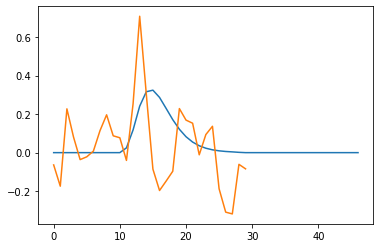

In [134]:
plt.plot(np.convolve(boxcar, two_gamma(two.params)))
plt.plot(pBOLD('ad', '02') / sum(pBOLD('ad', '03')))

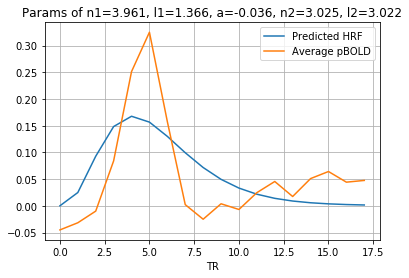

In [122]:
two.plot_gamma()

### 4.b Calculate average pBOLD signal across all the voxels(`'avg_pBOLD'`)

### 4.c Apply the LS algorithm to this 'avg_pBOLD' signal and estimate the $\theta$ parameters of this model.